# Compare the results of various experiments involving 1 robot for 1 day

This notebook creates graphs that compare the results of various experimental runs that involved running 1 robot for 1 day. 

This comparison is described by an exp/run of type 1robot1day, starting with the prefix comp_xxx. The sub-experiments are listed in that exp/run file.

The assumption is that those experiments had been already run and their results had been stored in the results.pickle files in the corresponding data dirs. 

In [23]:
import sys
sys.path.append("..")
from settings import Config
import pathlib
from pprint import pprint
import gzip as compress
import copy
import pickle
import matplotlib.pyplot as plt
import numpy as np

from WbfFigures import end_of_day_graphs, graph_env_im, add_robot_path

In [24]:
experiment = "1robot1day"

# the lead run is the one that will provide the test data.
# also the directory of this run is where the graphs will be saved.

# leadrun = "comp_all"
leadrun = "comp_ad"

# now load them

leadexp = Config().get_experiment(experiment, leadrun)

runs = leadexp["tocompare"]

exps = []
allresults = [ ]
for run in runs:
    exp = Config().get_experiment(experiment, run)
    exps.append(exp)
    resultsfile = pathlib.Path(exp["data_dir"], "results.pickle")
    if not resultsfile.exists():
        print(f"Results file does not exist:\n{resultsfile}")
        print("Run the notebook Run-1Robot1Day with the same exp/run to create it.")
        raise Exception("Nothing to do.")
    with compress.open(resultsfile, "rb") as f:
        results = pickle.load(f)
    allresults.append(results)

No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\1robot1day\comp_ad_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: 1robot1day/comp_ad successfully loaded
No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\1robot1day\fblm-ad-30_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: 1robot1day/fblm-ad-30 successfully loaded
No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\1robot1day\rwp-ad-30_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: 1robot1day/rwp-ad-30 successfully loaded


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'L', 'M', 'R', 'S', 'T', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'four', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 36, 37, 38, 39, 40, 41, 43, 47, 48, 53, 54, 55, 57, 60, 68, 69, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92, 3228]
INFO:fontTools.subset:Closed glyp

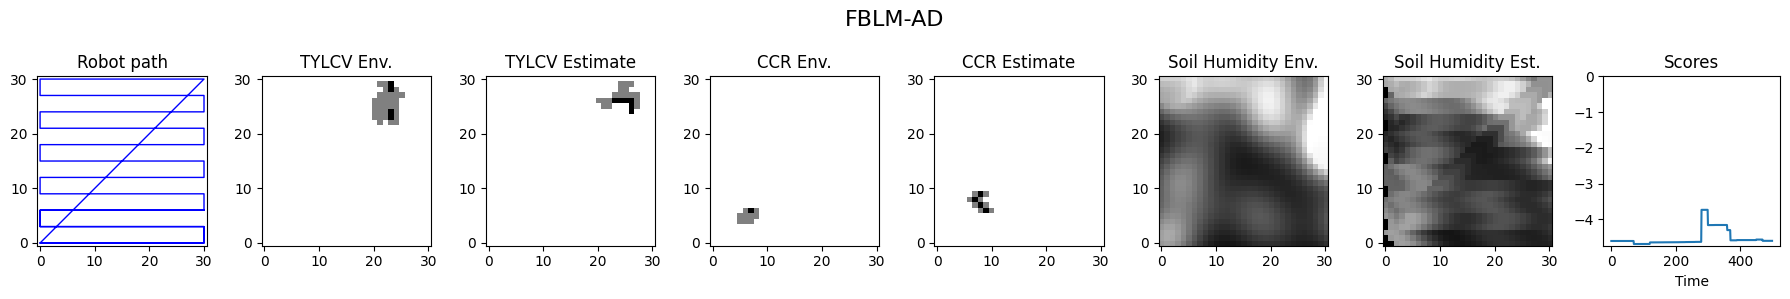

In [25]:
graphfilename = pathlib.Path(leadexp["data_dir"], "end-of-day.pdf")
end_of_day_graphs(allresults[0], graphfilename = graphfilename, plot_uncertainty = False)

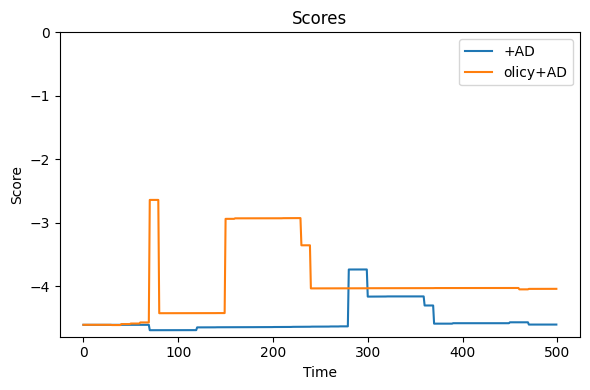

In [26]:
fig, ax_scores = plt.subplots(1, figsize=(6,4))
for results in allresults:
    ax_scores.plot(results["scores"], label = f'{results["policy-code"].name[len("benchmarkpaper-"):]}+{results["estimator-code"].name}')
ax_scores.set_ylim(top=0)
ax_scores.set_xlabel("Time")
ax_scores.set_ylabel("Score")
ax_scores.set_title("Scores")
ax_scores.legend()
fig.tight_layout()

In [29]:
horizontal = True
labels = ["food", "bar"]
metric="tylcv"
uncmap = "inferno" # was "grey", "viridis"

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 24, 42, 68, 69, 70, 71, 72, 73, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO:fontTools.subset:Closed glyph list over 'MATH': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'h', 'i', 'l', '

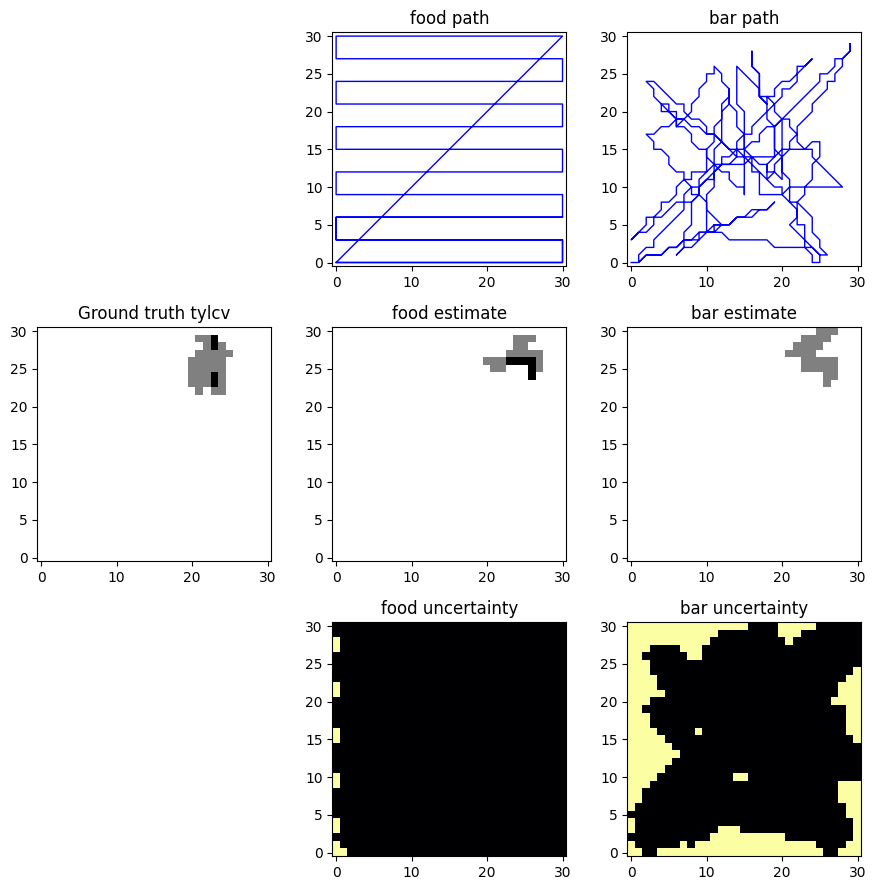

In [30]:
if horizontal:
    fig, axes = plt.subplots(nrows=3, ncols=(1+len(labels)), figsize=(3*(1+len(labels)),  3*3))
    #b = [ a[i][0] for i in range(len(a))]
    firstax = [ axes[i][0] for i in range(len(axes))]
else:    
    fig, axes = plt.subplots(nrows=(1+len(labels)), ncols=3, figsize=(3*3,3*(1+len(labels))))
    firstax = axes[0]
# print(firstax)
firstax[0].axis('off')
firstax[2].axis('off')

# graph_env_im(allresults[labels[0]]["wbfe"], allresults[labels[0]]["estimator-code"], ax_env_tylcv=axes[0][1])
graph_env_im(allresults[0]["wbfe"], allresults[0]["estimator-code"], **{f"ax_env_{metric}":firstax[1]})
axes[1][0].set_title(f"Ground truth {metric}")
filename = f"gt-{metric}-"
for i, label in enumerate(labels):        
    results = allresults[i]
    filename += label + "-"
    if horizontal:
        axrow = [ axes[j][i+1] for j in range(len(axes))]
        #axrow = axes[:][i+1]
    else:    
        axrow = axes[i+1]
    # empty = np.ones_like(results["wbfe"].tylcv.value.T)
    empty = np.ones_like(vars(results["wbfe"])[metric].value.T)
    image_env = axrow[0].imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")    
    add_robot_path(results, axrow[0], draw_robot = False)
    # graph_env_im(results["wbfe"], results["estimator-code"], ax_im_tylcv=axrow[1])
    graph_env_im(results["wbfe"], results["estimator-code"], **{f"ax_im_{metric}" : axrow[1]})
    # graph_env_im(results["wbfe"], results["estimator-code"], ax_unc_tylcv = axrow[2], cmap=uncmap)
    graph_env_im(results["wbfe"], results["estimator-code"], cmap=uncmap, **{f"ax_unc_{metric}": axrow[2]})
    axrow[0].set_title(f"{label} path")
    axrow[1].set_title(f"{label} estimate")
    axrow[2].set_title(f"{label} uncertainty")
plt.tight_layout()
filename = filename[:-1] + ".pdf"
plt.savefig(pathlib.Path(results["results-basedir"], filename)) 